In [14]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg16
from sklearn.manifold import TSNE
import time

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Experiment configuration
data_augmentation = True
batch_size_var = 512
batch_norm_var = True
l2 = True
scheduler_bool = True
early_stop = True


# number of steps for early stopping
early_stop_thresh = 3
# number of epochs
num_epochs = 100

In [16]:
device

device(type='cuda')

# Data Normalization

In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Data Loading

In [18]:
trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size_var, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size_var, shuffle=False)


Files already downloaded and verified


# Data augmentation transformation

In [19]:
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a new dataset with augmented images

In [20]:
augmented_dataset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=augmentation_transform)

# Concatenate the original trainset with the augmented dataset
combined_trainset = ConcatDataset([trainset, augmented_dataset])

# Create DataLoader for the combined training set only if we want it
if data_augmentation:
    train_loader = DataLoader(combined_trainset, batch_size=batch_size_var, shuffle=True)
    print("Using data augmentation")
else:
    print("No data augmentation")

Files already downloaded and verified
Using data augmentation


In [21]:
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([512, 3, 32, 32]) torch.Size([512])


In [22]:
# Compare sizes of the original trainset and the augmented combined trainset
original_trainset_size = len(trainset)
augmented_trainset_size = len(augmented_dataset)
combined_trainset_size = len(combined_trainset)

print(f"Original Trainset Size: {original_trainset_size}")
print(f"Augmented Trainset Size: {augmented_trainset_size}")
print(f"Combined Trainset Size: {combined_trainset_size}")

Original Trainset Size: 50000
Augmented Trainset Size: 50000
Combined Trainset Size: 100000


In [23]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


# Setting up functions

In [24]:
# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within the valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

# Function to visualize filters
def visualize_filters(model, layer_idx):
    layer = model[layer_idx]
    filters = layer.weight.data.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(filters.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filters[i, 0], cmap='gray')
        plt.axis('off')

    plt.show()

# Function to visualize activations
def visualize_activations(model, layer_idx, input_image):
    model = model.eval()
    activation = None

    def hook(module, input, output):
        nonlocal activation
        activation = output.data.cpu().numpy()

    layer = model[layer_idx]
    hook_handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        model(input_image.unsqueeze(0).to(device))

    hook_handle.remove()

    plt.figure(figsize=(10, 10))
    for i in range(activation.shape[1]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(activation[0, i], cmap='viridis')
        plt.axis('off')

    plt.show()

# Function to get top-k samples per unit
def get_top_k_samples(model, layer_idx, k, data_loader):
    model = model.eval()
    activations = []

    def hook(module, input, output):
        activations.append(output.data.cpu().numpy())

    layer = model[layer_idx]
    hook_handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            model(inputs)

    hook_handle.remove()

    activations = np.concatenate(activations, axis=0)
    top_k_samples = np.argsort(activations, axis=0)[-k:]

    return top_k_samples

# Function to show t-SNE plot
def show_tsne_plot(model, layer_idx, data_loader):
    model = model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.data.cpu().numpy())

    layer = model[layer_idx]
    hook_handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            model(inputs)

    hook_handle.remove()

    features = np.concatenate(features, axis=0)
    tsne = TSNE(n_components=2).fit_transform(features)

    plt.figure(figsize=(8, 8))
    plt.scatter(tsne[:, 0], tsne[:, 1])
    plt.title(f't-SNE Plot - Layer {layer_idx}')
    plt.show()

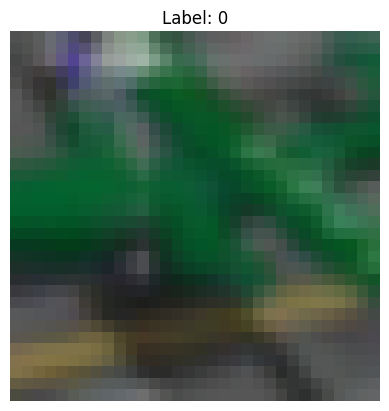

In [26]:
# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

# Model design

In [27]:
class CustomCNNCifar(nn.Module):
    def __init__(self, num_classes=10, batch_norm=True):
        super(CustomCNNCifar, self).__init__()
        self.batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 16x16x8
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 8x8x16
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 4x4x32
        if self.batch_norm:
            self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 2x2x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 1x1x64
        if self.batch_norm:
            self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64, num_classes)

        self.log_softmax = nn.LogSoftmax(dim=1)  # Softmax activation for classification

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.pool1(x)
        x = self.relu4(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.log_softmax(x)  # Apply softmax for classification
        return x

# SimpleCNNReduced

## Load the best model of SimpleCNNReduced from Task 2

In [28]:
# Load the saved model
loaded_model = CustomCNNCifar(num_classes=10, batch_norm=batch_norm_var)
loaded_model.load_state_dict(torch.load("best_model.pkl"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

CustomCNNCifar(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_featu

## Visualization

In [29]:
# Visualize filters in the first convolutional layer of your custom CNN model
visualize_filters(loaded_model, 0)

TypeError: ignored

In [ ]:
# Visualize activations in the first convolutional layer of your custom CNN model for a sample image
sample_image, _ = next(iter(test_loader))
sample_image = sample_image.to(device)
visualize_activations(loaded_model, 0, sample_image)

# Get top-k samples per unit in the first convolutional layer of your custom CNN model
top_k_samples_custom_model = get_top_k_samples(loaded_model, 0, 5, test_loader)
print(top_k_samples_custom_model)

# Show t-SNE plot on the first Fully Connected layer of your custom CNN model
show_tsne_plot(loaded_model, 11, test_loader)  # Adjust the layer index based on your model architecture

# VGG16

# Load pre-trained VGG16 model


In [31]:
vgg16_model = vgg16(pretrained=True).features
vgg16_model = vgg16_model.to(device)

In [57]:
# Load pre-trained VGG16 model
vgg16 = vgg16(pretrained=True)

# Count the number of layers in the 'features' module
num_layers = sum(1 for _ in vgg16.features.children())

print(f"Total number of layers in VGG16: {num_layers}")

Total number of layers in VGG16: 31


In [58]:
# Count the number of layers in the 'classifier' module
num_layers += sum(1 for _ in vgg16.classifier.children())

print(f"Total number of layers in VGG16 (including fully connected layers): {num_layers}")

Total number of layers in VGG16 (including fully connected layers): 38


## Visualization

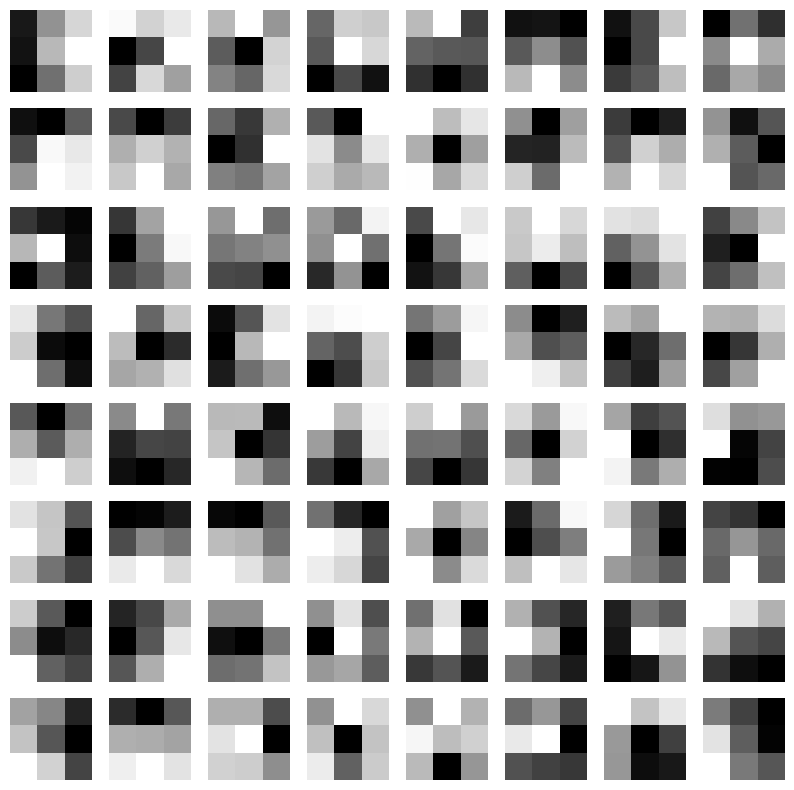

In [32]:
# Visualize filters in the first convolutional layer of VGG16
visualize_filters(vgg16_model, 0)

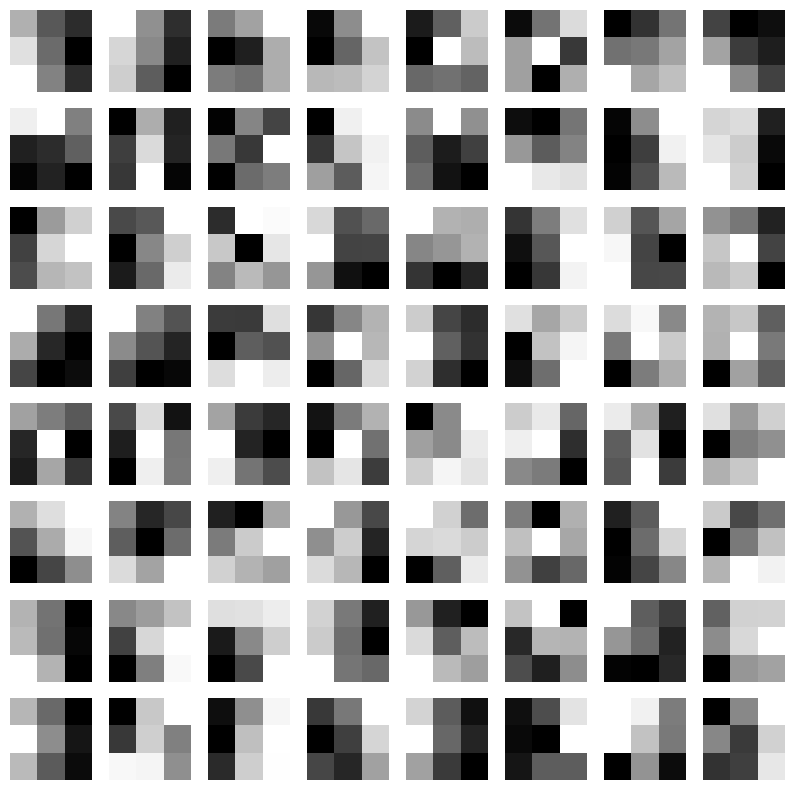

In [34]:
visualize_filters(vgg16_model, 2)

ValueError: ignored

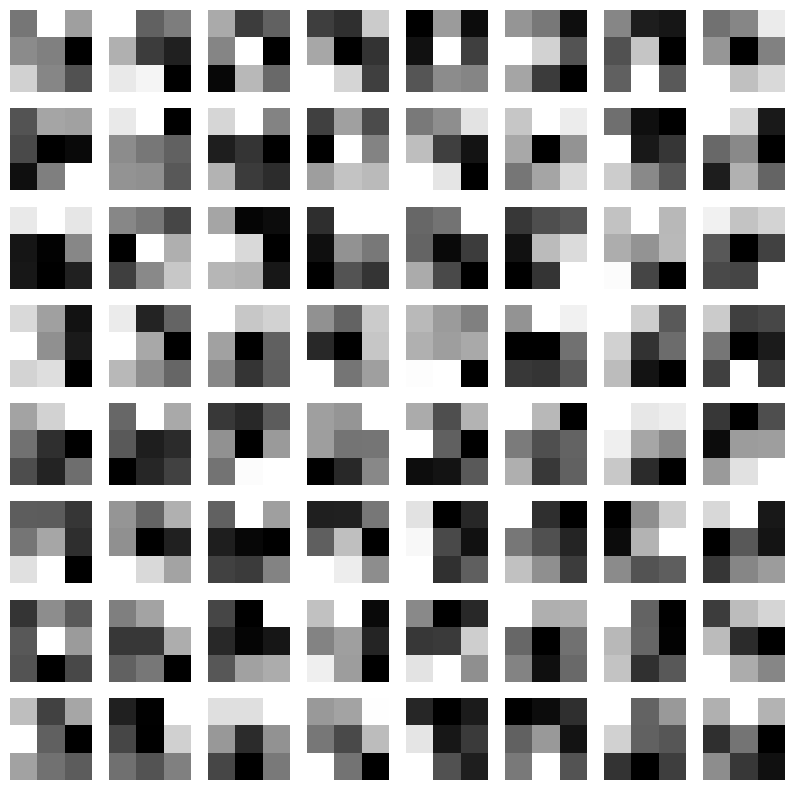

In [37]:
visualize_filters(vgg16_model, 5)

ValueError: ignored

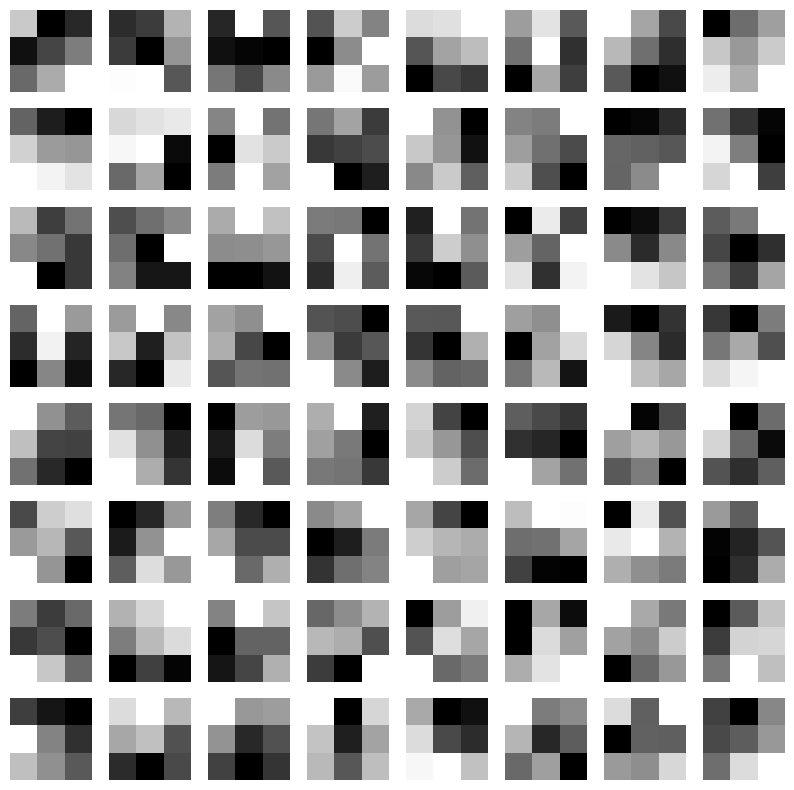

In [39]:
visualize_filters(vgg16_model, 7)

ValueError: ignored

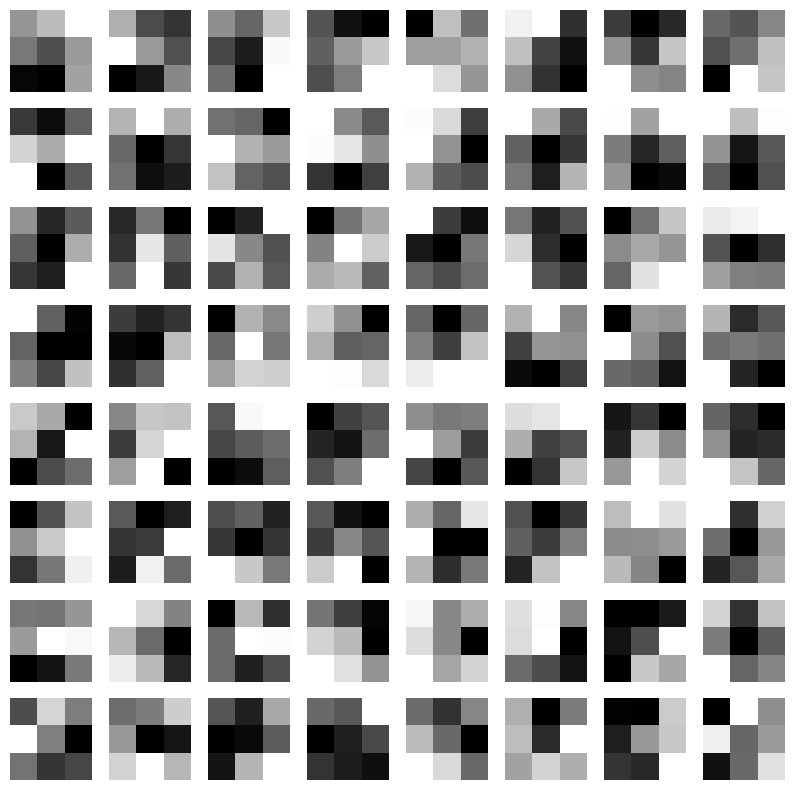

In [42]:
visualize_filters(vgg16_model, 10)

ValueError: ignored

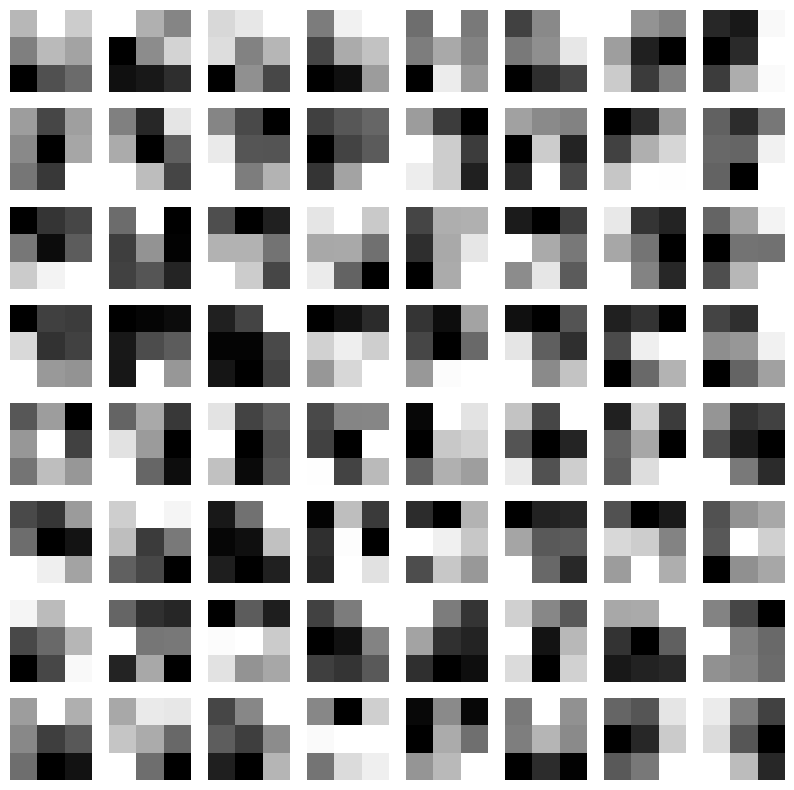

In [44]:
visualize_filters(vgg16_model, 12)

ValueError: ignored

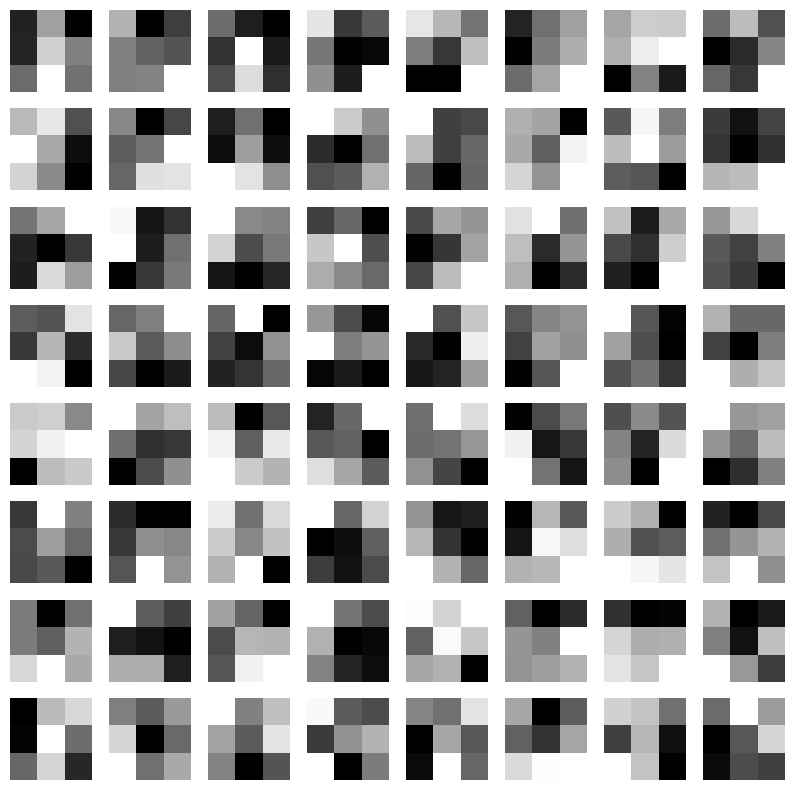

In [46]:
visualize_filters(vgg16_model, 14)

ValueError: ignored

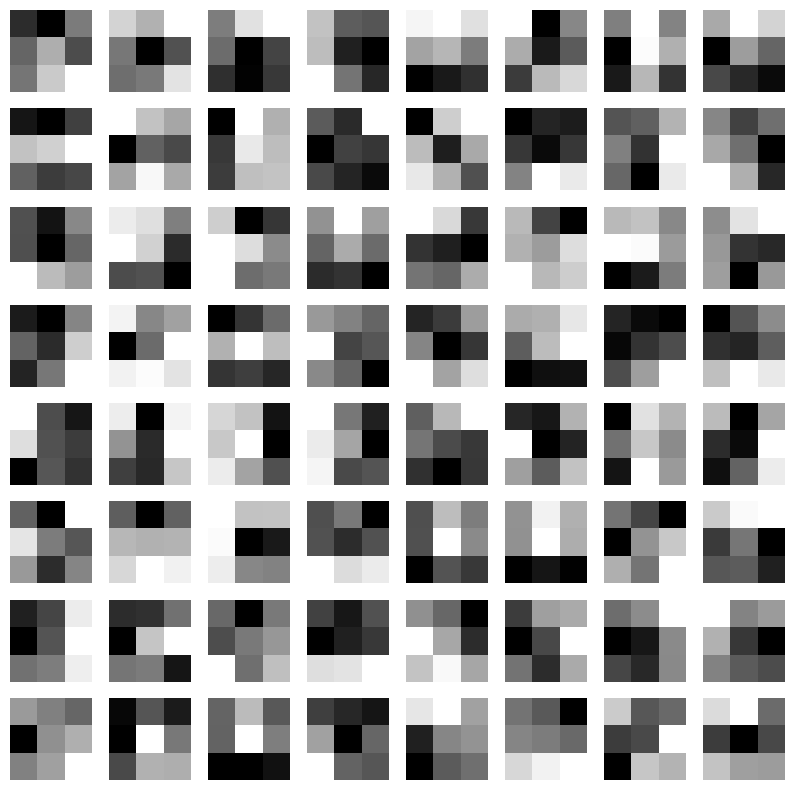

In [49]:
visualize_filters(vgg16_model, 17)

ValueError: ignored

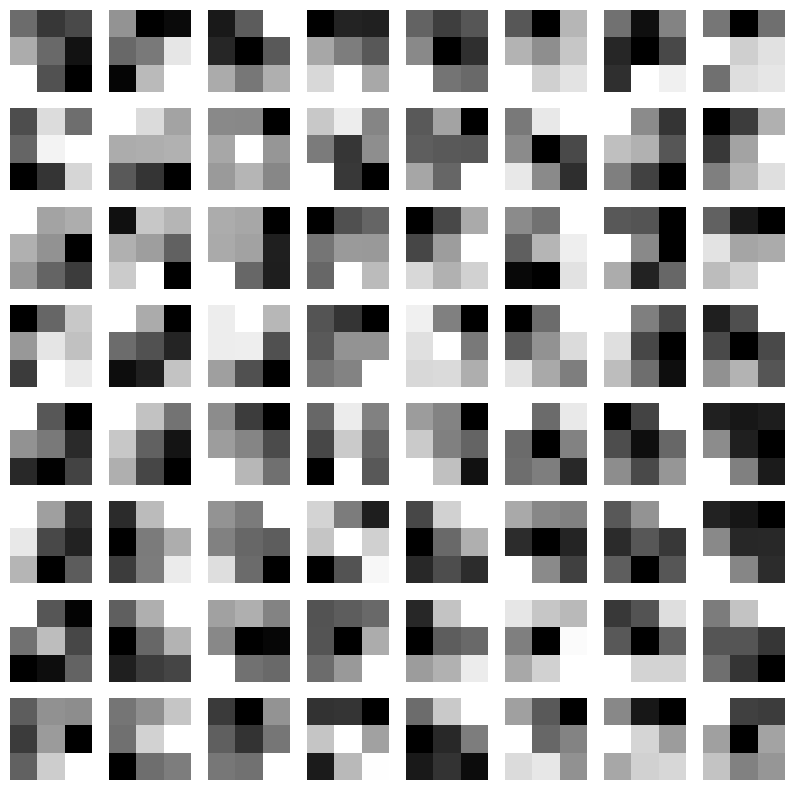

In [51]:
visualize_filters(vgg16_model, 19)

ValueError: ignored

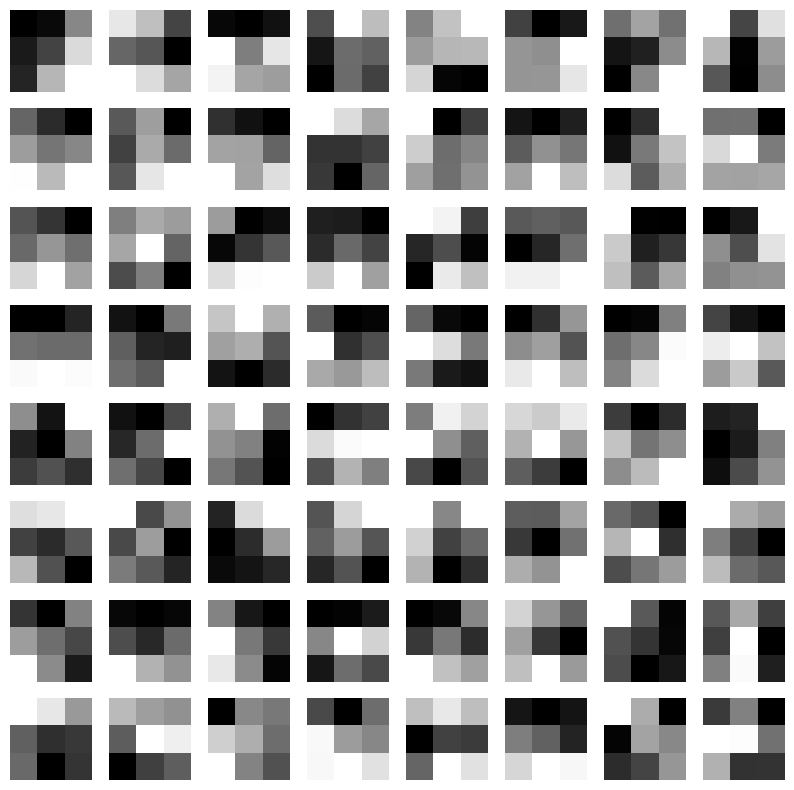

In [53]:
visualize_filters(vgg16_model, 21)

In [ ]:
# Visualize activations in the first convolutional layer of VGG16 for a sample image
sample_image, _ = next(iter(test_loader))
sample_image = sample_image.to(device)
visualize_activations(vgg16_model, 0, sample_image)

In [ ]:
# Get top-k samples per unit in the first convolutional layer of VGG16
top_k_samples = get_top_k_samples(vgg16_model, 0, 5, test_loader)
print(top_k_samples)

In [ ]:
# Show t-SNE plot on the first Fully Connected layer of VGG16
show_tsne_plot(vgg16_model, 6, test_loader)

!**Note**!: You may need to adjust the layer indices based on the architecture of your pre-trained VGG16 model. The layer indices provided in the code are just examples.